In [ ]:
# Mount Google dirve
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Project Folder
FOLDERNAME = 'Colab\ Notebooks/SC201_project'

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SC201_project


In [ ]:
# Define device
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device:', device)

Device: cuda


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# download MNIST dataset --> (1, 28*28)
# create mini batch meanwhile
mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.resize(28*28))])
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_val', train=False, download=True, transform=mnist_transform),
        batch_size=10, shuffle=True)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_train', train=True, download=True, transform=mnist_transform),
        batch_size=10, shuffle=True)

# hyperparameter
batch_size = 10
epoch = 1
learning_rate = 0.001
# num of adversarial examples
adver_nums = 100

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

simple_model = Net().to(device) # to cuda
optimizer1 = torch.optim.Adam(simple_model.parameters())
print (simple_model)

Net(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
# training model
def train(model,optimizer):
  for i in range(epoch):
    for j,(data,target) in tqdm(enumerate(train_loader)):
      model.train()
      data = data.to(device)
      target = target.to(device)
      logit = model(data)
      loss = F.cross_entropy(logit,target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if j % 1000 == 0:
        print ('第{}筆資料，loss值等於{}'.format(j,loss))
train(simple_model,optimizer1)

# validation process
def test(model,name):
  correct_num = torch.tensor(0).to(device)
  model.eval()
  with torch.no_grad():
    for j,(data,target) in tqdm(enumerate(test_loader)):
      data = data.to(device)
      target = target.to(device)
      logit = model(data)
      pred = logit.max(1)[1]
      # acc = pred.eq(target).sum().item() / 10000
      num = torch.sum(pred==target)
      correct_num = correct_num + num
    print (correct_num)
    # print ('\n{} correct rate is {}'.format(name, acc))
    print ('\n{} correct rate is {}'.format(name, correct_num / 10000))
test(simple_model,'simple model')

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
31it [00:02, 15.42it/s]

第0筆資料，loss值等於2.322784900665283


1060it [00:06, 305.37it/s]

第1000筆資料，loss值等於0.048337969928979874


2031it [00:09, 233.99it/s]

第2000筆資料，loss值等於0.24369004368782043


3038it [00:13, 305.60it/s]

第3000筆資料，loss值等於0.011442995630204678


4049it [00:16, 312.21it/s]

第4000筆資料，loss值等於0.20635707676410675


5048it [00:20, 311.73it/s]

第5000筆資料，loss值等於0.05454189330339432


6000it [00:23, 252.85it/s]
1000it [00:02, 359.18it/s]

tensor(9641, device='cuda:0')

simple model correct rate is 0.9641000032424927


In [ ]:
## generate JSMA attack

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# calculate jacobian matrix for forward deviation
def compute_jacobian(model, input):
    var_input = input.clone()

    var_input.detach_()
    var_input.requires_grad = True
    output = model(var_input)

    num_features = int(np.prod(var_input.shape[1:]))
    jacobian = torch.zeros([output.size()[1], num_features])
    for i in range(output.size()[1]):
        # zero_gradients(input)
        if var_input.grad is not None:
          var_input.grad.zero_()
        # output.backward(mask,retain_graph=True)
        output[0][i].backward(retain_graph=True)
        # copy the derivative to the target place
        jacobian[i] = var_input.grad.squeeze().view(-1, num_features).clone()

    return jacobian.to(device)

In [ ]:
# Saliency map calcuation

def saliency_map(jacobian, target_index, increasing, search_space, nb_features):
    domain = torch.eq(search_space, 1).float()  # The search domain
    # the sum of all features' derivative with respect to each class
    all_sum = torch.sum(jacobian, dim=0, keepdim=True)
    target_grad = jacobian[target_index]  # The forward derivative of the target class
    others_grad = all_sum - target_grad  # The sum of forward derivative of other classes

    # this list blanks out those that are not in the search domain
    if increasing:
        increase_coef = 2 * (torch.eq(domain, 0)).float().to(device)
    else:
        increase_coef = -1 * 2 * (torch.eq(domain, 0)).float().to(device)
    increase_coef = increase_coef.view(-1, nb_features)

    # calculate sum of target forward derivative of any 2 features.
    target_tmp = target_grad.clone()
    target_tmp -= increase_coef * torch.max(torch.abs(target_grad))
    alpha = target_tmp.view(-1, 1, nb_features) + target_tmp.view(-1, nb_features, 1)  # PyTorch will automatically extend the dimensions

    # calculate sum of other forward derivative of any 2 features.
    others_tmp = others_grad.clone()
    others_tmp += increase_coef * torch.max(torch.abs(others_grad))
    beta = others_tmp.view(-1, 1, nb_features) + others_tmp.view(-1, nb_features, 1)

    # zero out the situation where a feature sums with itself
    tmp = np.ones((nb_features, nb_features), int)
    np.fill_diagonal(tmp, 0)
    zero_diagonal = torch.from_numpy(tmp).byte().to(device)

    # According to the definition of saliency map in the paper (formulas 8 and 9),
    # those elements in the saliency map that doesn't satisfy the requirement will be blanked out.
    if increasing:
        mask1 = torch.gt(alpha, 0.0)
        mask2 = torch.lt(beta, 0.0)
    else:
        mask1 = torch.lt(alpha, 0.0)
        mask2 = torch.gt(beta, 0.0)
    # apply the mask to the saliency map
    mask = torch.mul(torch.mul(mask1, mask2), zero_diagonal.view_as(mask1))
    # do the multiplication according to formula 10 in the paper
    saliency_map = torch.mul(torch.mul(alpha, torch.abs(beta)), mask.float())
    # get the most significant two pixels
    max_value, max_idx = torch.max(saliency_map.view(-1, nb_features * nb_features), dim=1)
    p = max_idx // nb_features
    q = max_idx % nb_features
    return p, q, saliency_map

In [ ]:
def perturbation_single(image, ys_target, theta, gamma, model):

    copy_sample = np.copy(image)
    var_sample =Variable(torch.from_numpy(copy_sample), requires_grad=True).to(device)

    # outputs = model(var_sample)
    # predicted = torch.max(outputs.data, 1)[1]
    # print('测试样本扰动前的预测值：{}'.format(predicted[0]))

    var_target = Variable(torch.LongTensor([ys_target,])).to(device)

    if theta > 0:
        increasing = True
    else:
        increasing = False

    num_features = int(np.prod(copy_sample.shape[1:]))
    shape = var_sample.size()

    # perturb two pixels in one iteration, thus max_iters is divided by 2.0
    max_iters = int(np.ceil(num_features * gamma / 2.0))

    # masked search domain, if the pixel has already reached the top or bottom, we don't bother to modify it.
    if increasing:
        search_domain = torch.lt(var_sample, 0.99) #逐一元素比較var_sample和0.99
    else:
        search_domain = torch.gt(var_sample, 0.01)
    search_domain = search_domain.view(num_features)

    model.eval().to(device)
    output = model(var_sample)
    current = torch.max(output.data, 1)[1].cpu().numpy()
    saliency = torch.zeros((1, 784, 784)).to(device)

    iter = 0
    while (iter < max_iters) and (current[0] != ys_target) and (search_domain.sum() != 0):
        # calculate Jacobian matrix of forward derivative
        jacobian = compute_jacobian(model, var_sample)
        # get the saliency map and calculate the two pixels that have the greatest influence
        p1, p2, s = saliency_map(jacobian, var_target, increasing, search_domain, num_features)
        saliency += s
        # apply modifications
        var_sample_flatten = var_sample.view(-1, num_features).clone().detach_()
        var_sample_flatten[0, p1] += theta
        var_sample_flatten[0, p2] += theta

        new_sample = torch.clamp(var_sample_flatten, min=0.0, max=1.0)
        new_sample = new_sample.view(shape)
        search_domain[p1] = 0
        search_domain[p2] = 0
        var_sample = Variable(torch.tensor(new_sample), requires_grad=True ).to(device)

        output = model(var_sample)
        current = torch.max(output.data, 1)[1].cpu().numpy()
        iter += 1

    adv_samples = var_sample.data.cpu().numpy()
    return adv_samples, saliency

In [ ]:
# 建立以下變數，作為視覺化用
adver_example_by_JSMA = torch.zeros((batch_size,1,28,28)).to(device)
adver_target = torch.zeros(batch_size).to(device)
clean_example = torch.zeros((batch_size,1,28,28)).to(device)
clean_target = torch.zeros(batch_size).to(device)
saliency_m = torch.zeros((batch_size, 1, 784, 784)).to(device)
# saliency_m = None
pert_diff = torch.zeros((batch_size)).to(device)

theta = 1.0 # 調整項
gamma = 0.1 # 最大擾動特徵數占總特徵數的比例
ys_target= 8 # targeted output

# 從test_loader中選100個clear example，使用JSMA生成adversarial examples
for i,(data,target) in enumerate(test_loader):
  if i >= adver_nums/batch_size :
    break
  if i == 0:
    clean_example = data
  else:
    clean_example = torch.cat((clean_example,data),dim = 0)

  cur_adver_example_by_JSMA = torch.zeros_like(data).to(device)
  saliency = torch.zeros((10, 784, 784)).to(device)
  pert = torch.zeros((10,)).to(device)

  for j in range(batch_size):
        # image = testdata[index][0].resize_(1,784).numpy() # 测试样本特征
    # data1 = data[j]
    # print (data.shape)
    pert_image, sal = perturbation_single(data[j].resize_(1,28*28).numpy(),ys_target,theta,gamma,simple_model)
    saliency[j] = sal
    cur_adver_example_by_JSMA[j] = torch.from_numpy(pert_image).to(device)

    pert_diff_one = cur_adver_example_by_JSMA[j] - data[j].to(device)
    pert[j] = torch.sum(pert_diff_one) / 784
  pert = torch.sum(pert) / batch_size

  # attack model (LeNet)
  pred = simple_model(cur_adver_example_by_JSMA).max(1)[1]
  if i == 0:
    adver_example_by_JSMA = cur_adver_example_by_JSMA
    clean_target = target
    adver_target = pred
    saliency_m = saliency
    pert_diff = pert
  else:
    adver_example_by_JSMA = torch.cat((adver_example_by_JSMA , cur_adver_example_by_JSMA), dim = 0)
    clean_target = torch.cat((clean_target,target),dim = 0)
    adver_target = torch.cat((adver_target,pred),dim = 0)
    saliency_m = torch.cat((saliency_m, saliency), dim=0)
    pert_diff += pert

avg_pert = torch.sum(pert_diff) / 10

print (adver_example_by_JSMA.shape)
# print (adver_target)
print (clean_example.shape)
# print (clean_target)
print(avg_pert)

<ipython-input-8-3d63487e6aaa>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var_sample = Variable(torch.tensor(new_sample), requires_grad=True ).to(device)


torch.Size([100, 784])
torch.Size([100, 784])
tensor(0.0680, device='cuda:0')


In [ ]:
import random
batch = np.random.choice(len(adver_example_by_JSMA), 1)
adv = adver_example_by_JSMA[batch].to(device)
clean = clean_example[batch].to(device)
pert_one = adv - clean
avg_pert_one = torch.sum(pert_one) / 784
print(avg_pert_one)

tensor(0.0248, device='cuda:0')


In [ ]:
# visualizatioin

def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target, saliency):
  n_cols = 5
  n_rows = 5
  cnt = 1
  cnt1 = 1
  # cnt2 = 1
  plt.figure(figsize=(n_cols*4,n_rows*2))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*3,cnt1)
      plt.xticks([])
      plt.yticks([])
      plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(clean_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*3,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      plt.title("{}".format(str(ys_target)))
      plt.imshow(saliency[cnt].squeeze().to('cpu').numpy(),cmap=plt.cm.hot)
      plt.subplot(n_cols,n_rows*3,cnt1+2)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 3
  plt.show()


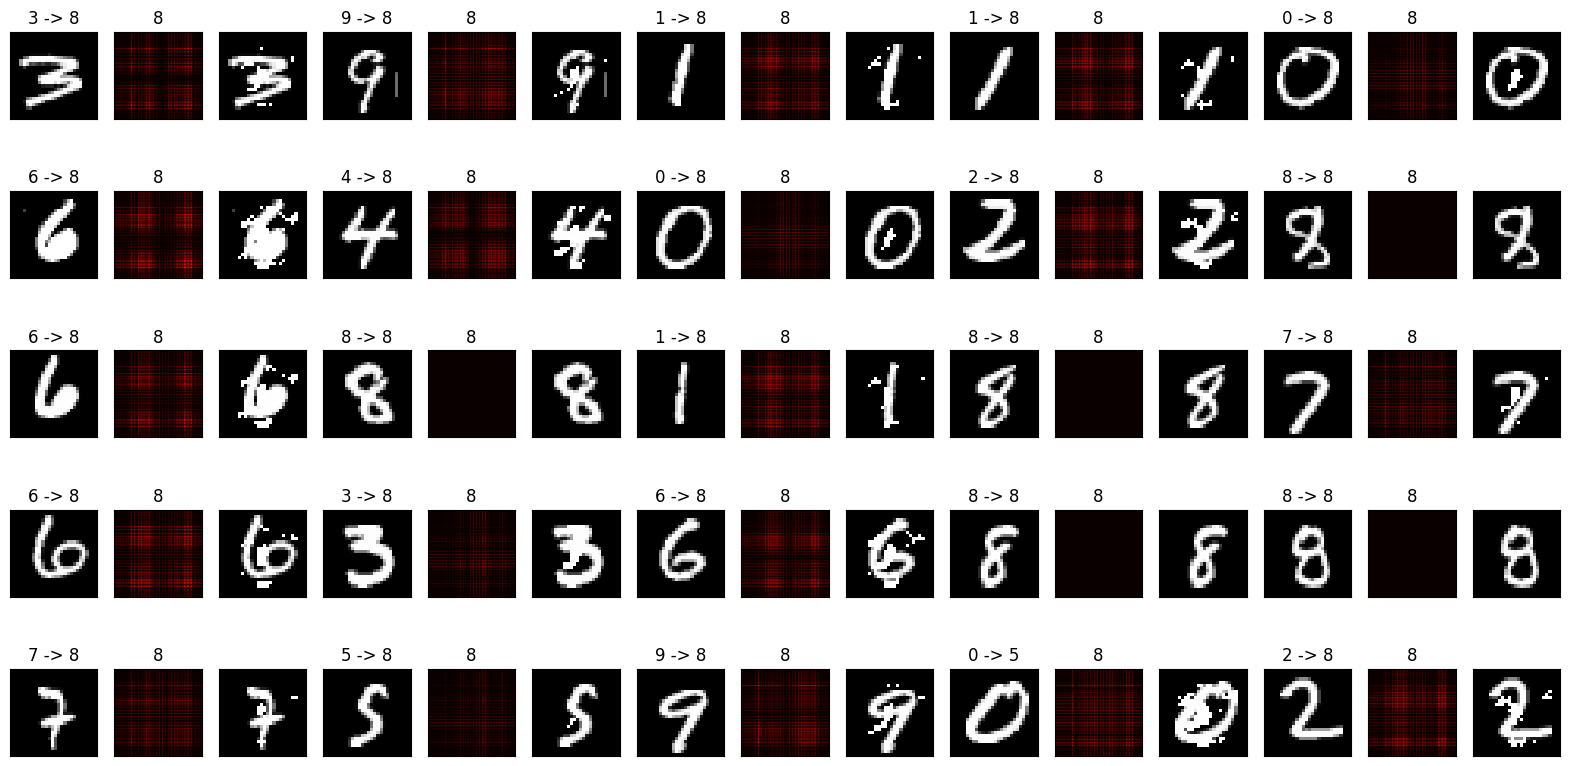

In [ ]:
plot_clean_and_adver(adver_example_by_JSMA,adver_target,clean_example,clean_target, saliency_m)

In [ ]:
import torch.utils.data as Data
def adver_attack(model,adver_example,target,name):
  adver_dataset = Data.TensorDataset(adver_example, target)
  loader = Data.DataLoader(
    dataset=adver_dataset,
    batch_size=batch_size
    )
  correct_num = torch.tensor(0).to(device)
  for j,(data,target) in tqdm(enumerate(loader)):
    data = data.to(device)
    target = target.to(device)
    pred = model.forward(data).max(1)[1]
    num = torch.sum(pred==target)
    correct_num = correct_num + num
  print (correct_num)
  print ('\n{} correct rate is {}'.format(name,correct_num/adver_nums))

adver_attack(simple_model,adver_example_by_JSMA,clean_target,'simple model')


10it [00:00, 744.42it/s]

tensor(11, device='cuda:0')

simple model correct rate is 0.10999999940395355


In [ ]:
# train model with adversarial examples
# need adver_example_by_JSMA and clean_target

# new model:
def train2(model,optimizer):
  batch = np.random.choice(adver_example_by_JSMA.shape[0], batch_size)
  adver_example_by_JSMA_batch = adver_example_by_JSMA[batch]
  clean_target_batch = clean_target[batch]
  for i in range(epoch):
    for k in range(batch_size):
      for j in range(len(adver_example_by_JSMA)):
        data = adver_example_by_JSMA_batch.to(device)
        target = clean_target_batch.to(device)
        logit = model(data)
        loss = F.cross_entropy(logit,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
simple_model2 = simple_model
train2(simple_model2,optimizer1)

simple_model2.eval()
test(simple_model2,'simple model_adver_train')

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
1000it [00:02, 417.86it/s]

tensor(7247, device='cuda:0')

simple model_adver_train correct rate is 0.7246999740600586


In [ ]:
# re-gen adversarial examples by JSMA from simple_model 1

# 建立以下變數，作為視覺化用
adver_example_by_JSMA_re = torch.zeros((batch_size,1,28,28)).to(device)
adver_target_re = torch.zeros(batch_size).to(device)
clean_example_re = torch.zeros((batch_size,1,28,28)).to(device)
clean_target_re = torch.zeros(batch_size).to(device)
saliency_m_re = torch.zeros((batch_size, 1, 784, 784)).to(device)
# saliency_m = None

theta = 1.0 # 調整項
gamma = 0.1 # 最大擾動特徵數占總特徵數的比例
ys_target= 8 # targeted output

# 從test_loader中選100個clear example，使用JSMA生成adversarial examples
for i,(data,target) in enumerate(test_loader):
  if i >= adver_nums/batch_size :
    break
  if i == 0:
    clean_example_re = data
  else:
    clean_example_re = torch.cat((clean_example_re,data),dim = 0)

  cur_adver_example_by_JSMA_re = torch.zeros_like(data).to(device)
  saliency_re = torch.zeros((10, 784, 784)).to(device)

  for j in range(batch_size):
    pert_image, sal = perturbation_single(data[j].resize_(1,28*28).numpy(),ys_target,theta,gamma,simple_model)
    saliency_re[j] = sal
    cur_adver_example_by_JSMA_re[j] = torch.from_numpy(pert_image).to(device)

  # attack model (LeNet)
  pred = simple_model2(cur_adver_example_by_JSMA_re).max(1)[1]
  if i == 0:
    adver_example_by_JSMA_re = cur_adver_example_by_JSMA_re
    clean_target_re = target
    adver_target_re = pred
    saliency_m_re = saliency_re
  else:
    adver_example_by_JSMA_re = torch.cat((adver_example_by_JSMA_re , cur_adver_example_by_JSMA_re), dim = 0)
    clean_target_re = torch.cat((clean_target_re,target),dim = 0)
    adver_target_re = torch.cat((adver_target_re,pred),dim = 0)
    saliency_m_re = torch.cat((saliency_m_re, saliency_re), dim=0)

print (adver_example_by_JSMA_re.shape)
# print (adver_target)
print (clean_example_re.shape)
# print (clean_target)

<ipython-input-7-3d63487e6aaa>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var_sample = Variable(torch.tensor(new_sample), requires_grad=True ).to(device)


torch.Size([100, 784])
torch.Size([100, 784])


In [ ]:
# test after-attacking accuracy
adver_attack(simple_model2,adver_example_by_JSMA_re,clean_target_re,'simple model_adver_train')

10it [00:00, 1018.11it/s]

tensor(35, device='cuda:0')

simple model_adver_train correct rate is 0.3499999940395355


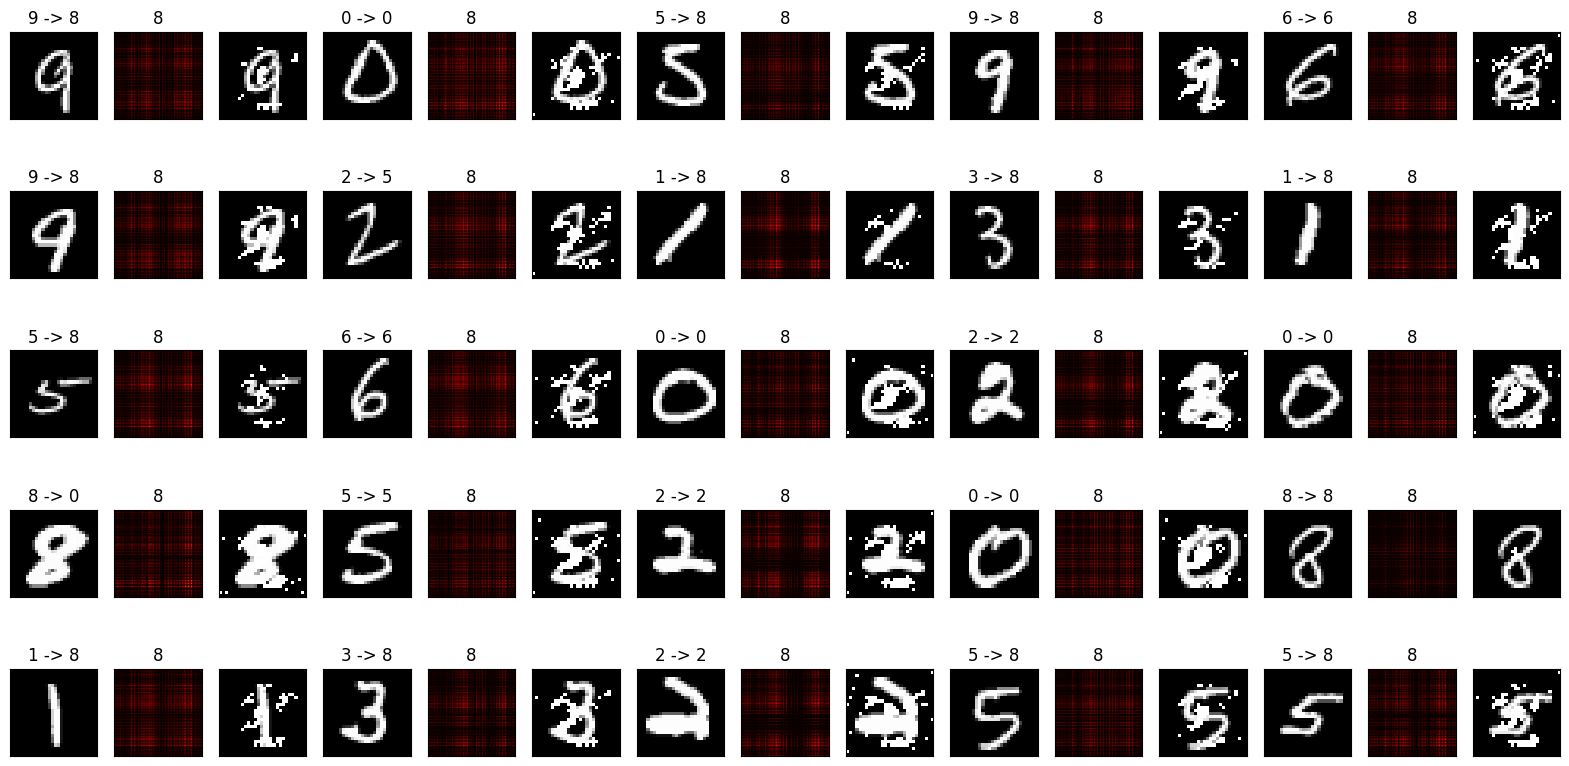

In [ ]:
plot_clean_and_adver(adver_example_by_JSMA_re,adver_target_re,clean_example_re,clean_target_re, saliency_m_re)

In [ ]:
# to see perturbation / gen new perturbation of target 8 from defense model

adver_example_by_JSMA_d = torch.zeros((batch_size,1,28,28)).to(device)
adver_target_d = torch.zeros(batch_size).to(device)
clean_example_d = torch.zeros((batch_size,1,28,28)).to(device)
clean_target_d = torch.zeros(batch_size).to(device)
saliency_m_d = torch.zeros((batch_size, 1, 784, 784)).to(device)
# saliency_m = None

theta = 1.0
gamma = 0.1
ys_target= 8

# 從test_loader中選100個clear example，使用JSMA生成adversarial examples
for i,(data,target) in enumerate(test_loader):
  if i >= adver_nums/batch_size :
    break
  if i == 0:
    clean_example_d = data
  else:
    clean_example_d = torch.cat((clean_example_d,data),dim = 0)

  cur_adver_example_by_JSMA_d = torch.zeros_like(data).to(device)
  saliency_d = torch.zeros((10, 784, 784)).to(device)

  for j in range(batch_size):
    pert_image_d, sal_d = perturbation_single(data[j].resize_(1,28*28).numpy(),ys_target,theta,gamma,simple_model)
    saliency_d[j] = sal_d
    cur_adver_example_by_JSMA_d[j] = torch.from_numpy(pert_image_d).to(device)

  # attack model (LeNet)
  pred = simple_model2(cur_adver_example_by_JSMA_d).max(1)[1]
  if i == 0:
    adver_example_by_JSMA_d = cur_adver_example_by_JSMA_d
    clean_target_d = target
    adver_target_d = pred
    saliency_m_d = saliency_d
  else:
    adver_example_by_JSMA_d = torch.cat((adver_example_by_JSMA_d , cur_adver_example_by_JSMA_d), dim = 0)
    clean_target_d = torch.cat((clean_target_d,target),dim = 0)
    adver_target_d = torch.cat((adver_target_d,pred),dim = 0)
    saliency_m_d = torch.cat((saliency_m_d, saliency_d), dim=0)

print (adver_example_by_JSMA_d.shape)
# print (adver_target)
print (clean_example_d.shape)
# print (clean_target)

<ipython-input-7-3d63487e6aaa>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var_sample = Variable(torch.tensor(new_sample), requires_grad=True ).to(device)


torch.Size([100, 784])
torch.Size([100, 784])


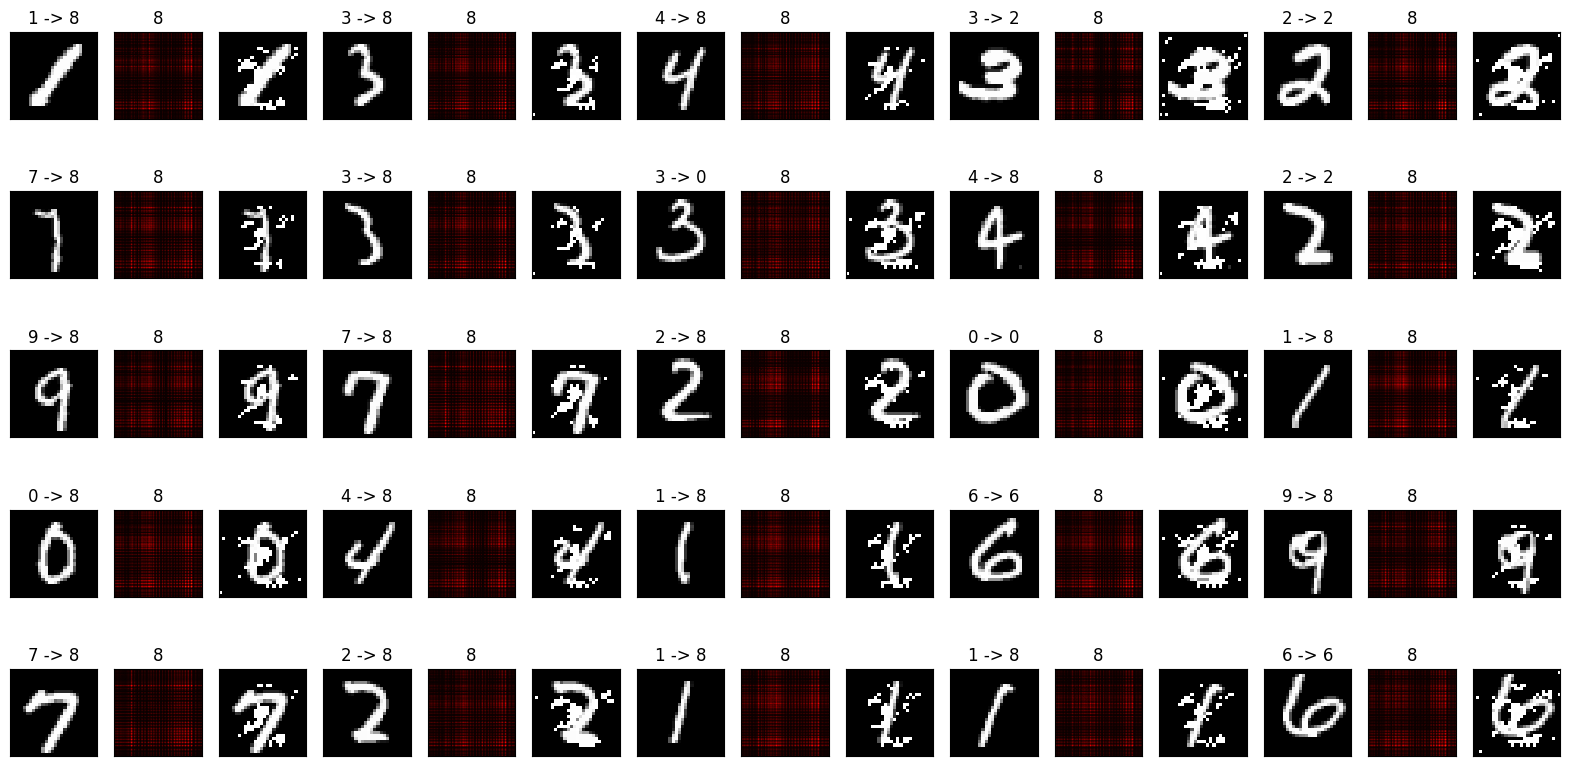

In [ ]:
# visualizatioin
plot_clean_and_adver(adver_example_by_JSMA_d,adver_target_d,clean_example_d,clean_target_d, saliency_m_d)

In [ ]:
# adversarial training
import random

adver_train_model = Net().to(device)

# set free adversarial training parameter
m = 2 # hop steps
epoch_adv = 12
optimizer_adv = torch.optim.Adam(adver_train_model.parameters())

theta = 1.0 # 調整項
gamma = 0.1 # 最大擾動特徵數占總特徵數的比例

noise_data = torch.zeros((batch_size,784)).to(device)
y_adv_target = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def adv_train(model,optimizer):
  for i in range(epoch_adv//m):
    for j,(data,target) in tqdm(enumerate(train_loader)):
      data = data.to(device)
      target = target.to(device)
      # print(data.shape)
      # print(target.shape)
      for k in range(m):
        noise = Variable(noise_data[0:data.size(0)], requires_grad=True).to(device)
        input = data + noise
        # print(noise_data.shape)

        output = model(input)
        loss = F.cross_entropy(output,target)

        optimizer.zero_grad()
        loss.backward()

        # update noise
        y_adv = random.choice(y_adv_target)
        for batch in range(len(data)):
          pert, _ = perturbation_single(data[batch].resize_(1,28*28).cpu().numpy(),y_adv,theta,gamma,model)
          noise_data[batch] = torch.from_numpy(pert).to(device)
          noise_data[batch] -= data[batch]

        optimizer.step()


      if j % 1000 == 0:
        print('第{}筆資料，loss值等於{}'.format(j,loss))

In [ ]:
adv_train(adver_train_model,optimizer_adv)

In [ ]:
# validation process
def test(model,name):
  correct_num = torch.tensor(0).to(device)
  # with torch.no_grad():
  for j,(data,target) in tqdm(enumerate(test_loader)):
    data = data.to(device)
    target = target.to(device)
    logit = model(data)
    pred = logit.max(1)[1]
    # acc = pred.eq(target).sum().item() / 10000
    num = torch.sum(pred==target)
    correct_num = correct_num + num
  print (correct_num)
  # print ('\n{} correct rate is {}'.format(name, acc))
  print ('\n{} correct rate is {}'.format(name, correct_num / 10000))

In [ ]:
adver_train_model.eval()
test(adver_train_model,'adversarial training model')